# Monte Carlo relaxation of cluster means

Premise: Trends within each cluster can be trusted, but absolute values of clusters in relation to each other may not be accurate (due to variations in deposition and processing).

Hypothesis: If we assume that the "true" data (values if synthesis and processing were perfectly consistent, i.e. noiseless) should be such that the relationship between features and the response is consistent across different clusters, then we can estimate the "true" data by shifting the cluster means to find the configuration that gives the best model fit across clusters.

Approach: Hold out one cluster for validation and use other clusters as training set. Use Monte Carlo to shift means of the training clusters while maintaining trends within each cluster. At each step, fit a model to the shifted training clusters. The energy of the configuration is the model error (residual sum of squares) plus a penalty (sum of squared shifts - should be Gaussian prior) to account for how much the cluster means have been shifted. Relax the energy of the training set, then use the resulting model to predict the validation cluster (which has not been shifted).

Results: All clusters in training set tend to be shifted toward the overall cluster mean. Ability to predict the validation cluster is not improved.

In [1]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.pickletools import pickle_dict
from helpers.plotting import quat_slice_scatter, add_colorbar, scatter_slices
from helpers.quaternary_plt import QuaternaryAxes
from helpers.outlier_detect import DataCleaner

import pymatgen as mg
import pypif.pif

from ipywidgets import interact

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [360]:
#cell below disables auto-scrolling subwindow in cell output
#cannot have any other code in the cell (even comments) or it breaks

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
} 

<IPython.core.display.Javascript object>

In [3]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis') 
#pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/eis/plots')
pickledir = os.path.join(tcodir,'scripts/pickles')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

## ASR

In [4]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['ASR'] > 0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_ASR'] = np.log10(data['ASR'])

In [5]:
data['sample'].unique()

array(['PDAC_COM3_01488', 'PDAC_COM3_01504', 'PDAC_COM3_01533',
       'PDAC_COM3_01535', 'PDAC_COM3_01564'], dtype=object)

In [7]:
help(scatter_slices)

Help on function scatter_slices in module helpers.plotting:

scatter_slices(data, z, slice_axis, slice_starts, slice_widths, tern_axes, axes=None, ncols=2, figsize=None, colorbar=True, cmap=<matplotlib.colors.ListedColormap object at 0x0000020D1D029128>, vmin=None, vmax=None, titles=True, titlesize=14, titlebox_props={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5}, **slice_scatter_kw)



Scale: 0.95
Scale: 0.85


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000150EFAE1A58>,
      dtype=object)

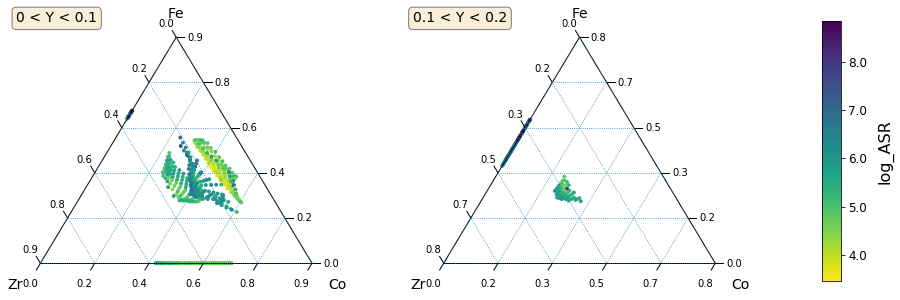

In [5]:
scatter_slices(data,'log_ASR','Y',[0,0.1],0.1,tern_axes=['Co','Fe','Zr'],cmap=plt.cm.viridis_r)

In [6]:
dc = DataCleaner(data,'log_ASR',DB_kw={'eps':0.25},IF_kw={'contamination':0.1})
dc.fit_predict(z_thresh=2)
dc.reduce_comp_dims()

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


['Co', 'Fe', 'Y', 'Zr']


(           v1        v2   log_ASR  outlier_flag  cluster
 0   -0.125241  2.317846  5.229463             0        0
 1    0.487762  1.942275  5.331189             0        0
 2    1.036206  1.737107  5.755452             0        0
 3    1.595512  1.434203  5.769734             0        0
 4    2.163922  1.201690  5.741600             0        0
 5    2.642002  0.882933  5.658158             0        0
 6    3.073398  0.567041  5.540512             0        0
 7    3.517331  0.490905  5.419439             0        0
 8    3.838214  0.279166  5.652820             0        0
 9    4.184973  0.197765  4.885002             0        0
 10   4.463048  0.207823  5.103424             0        0
 11  -0.313223  2.211021  5.091200             0        0
 12   0.271480  1.830734  5.396423             0        0
 13   0.812707  1.611678  5.352196             0        0
 14   1.357833  1.267979  5.328380             0        0
 15   1.929043  1.020817  5.504300             0        0
 16   2.404607

In [7]:
#get cluster number for each sample
np.unique(dc.data_pred['sample'] + ' - ' + dc.data_pred['cluster'].astype(str))

array(['PDAC_COM3_01488 - 0', 'PDAC_COM3_01504 - 1',
       'PDAC_COM3_01533 - 2', 'PDAC_COM3_01535 - 3',
       'PDAC_COM3_01564 - 4'], dtype=object)

(-6.918973112431612, 7.937921148286253)

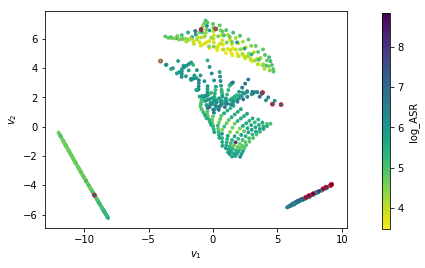

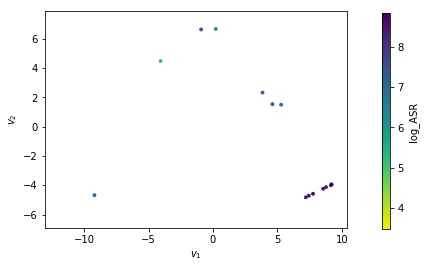

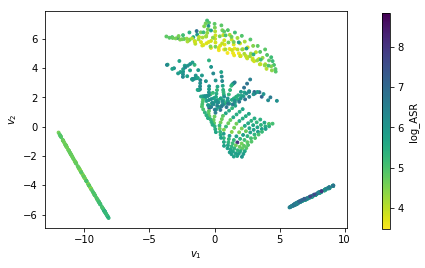

In [8]:
ax = dc.reduced_highlight_plot(cmap=plt.cm.viridis_r)
axo = dc.reduced_outlier_plot(s=8,cmap=plt.cm.viridis_r)
axi = dc.reduced_inlier_plot(s=8,cmap=plt.cm.viridis_r)
axo.set_xlim(ax.get_xlim())
axo.set_ylim(ax.get_ylim())

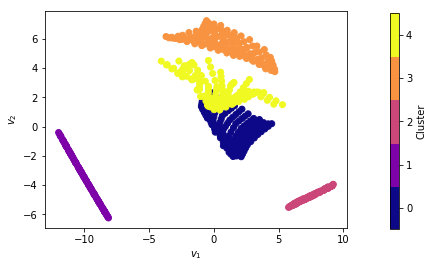

In [9]:
dc.reduced_cluster_plot()

[0 1 2 3 4]
3


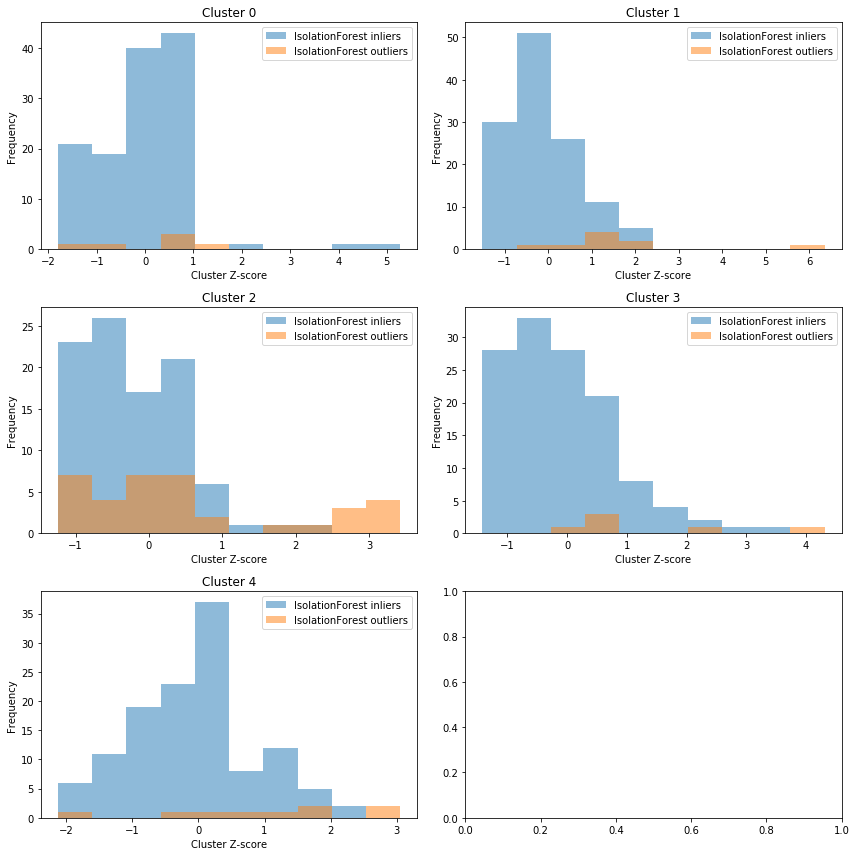

In [10]:
dc.cluster_hist()

In [11]:
dc.remove_outliers()
clean_data = dc.clean_data

In [12]:
#load pickles
calc_feat_Co23Fe34 = pickle_dict(os.path.join(pickledir,'feat_Co23Fe34'))
calc_feat_Co24Fe24 = pickle_dict(os.path.join(pickledir,'feat_Co24Fe24'))

In [14]:
input_2334 = pd.DataFrame()
input_2424 = pd.DataFrame()
y = clean_data['log_ASR']
#calculate features
for idx in clean_data.index:
    row = clean_data.loc[idx,:]
    formula = row['formula']
    try:
        f2334 = calc_feat_Co23Fe34.dict[formula]
    except KeyError:
        f2334 = formula_redfeat(formula,cat_ox_lims={'Co':[2,3],'Fe':[3,4]})
        calc_feat_Co23Fe34.dict[formula] = f2334
    try:
        f2424 = calc_feat_Co24Fe24.dict[formula]
    except KeyError:
        f2424 = formula_redfeat(formula,cat_ox_lims={'Co':[2,4],'Fe':[2,4]})
        calc_feat_Co24Fe24.dict[formula] = f2424
        
    f2334['formula'] = formula
    input_2334 = input_2334.append(pd.Series(f2334),ignore_index=True)
    f2424['formula'] = formula
    input_2424 = input_2424.append(pd.Series(f2424),ignore_index=True)

calc_feat_Co23Fe34.update_file()
calc_feat_Co24Fe24.update_file()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co23Fe34
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co24Fe24


In [100]:
input_2334.drop('formula',axis=1)

,A:B_ratio,A_sum,B_sum,Ba_amt,Co:Fe_ratio,Co_amt,Fe_amt,MO_ABE,MO_IC_a,MO_IC_avg,...,n_b_oxavg,r_a_oxavg,r_b_oxavg,r_b_std_oxavg,r_crit_oxavg,tau_oxavg,tot_cat_charge_oxavg,trans_met_amt,uc_vol_free_oxavg,uc_vol_oxavg
0,0.911620,0.91162,1.00000,0.91162,1.337882,0.40788,0.30487,-308.775808,0.803211,0.658297,...,3.181055,1.61,0.680498,0.074294,0.934734,3.561819,5.004295,0.71275,29.565791,77.133756
1,0.909561,0.90957,1.00001,0.90957,1.179855,0.37871,0.32098,-311.417982,0.803211,0.659810,...,3.215963,1.61,0.680191,0.074963,0.934840,3.561240,5.035135,0.69969,29.391160,77.133756
2,0.919729,0.91972,0.99999,0.91972,1.053234,0.35613,0.33813,-313.627133,0.803211,0.661379,...,3.240642,1.61,0.679457,0.075518,0.935097,3.561761,5.080050,0.69426,29.137860,77.133756
3,0.912380,0.91238,1.00000,0.91238,0.937619,0.33097,0.35299,-314.964781,0.803211,0.662256,...,3.265960,1.61,0.679866,0.077341,0.934950,3.560230,5.090720,0.68396,29.074754,77.133756
4,0.916340,0.91634,1.00000,0.91634,0.828826,0.30742,0.37091,-316.531840,0.803211,0.663442,...,3.289065,1.61,0.679572,0.078619,0.935051,3.560081,5.121745,0.67833,28.898646,77.133756
5,0.913190,0.91319,1.00000,0.91319,0.741282,0.28463,0.38397,-318.130369,0.803211,0.664530,...,3.312700,1.61,0.679893,0.079985,0.934936,3.558905,5.139080,0.66860,28.797606,77.133756
6,0.913000,0.91300,1.00000,0.91300,0.664511,0.26403,0.39733,-319.928852,0.803211,0.665449,...,3.338520,1.61,0.679078,0.079666,0.935223,3.559843,5.164520,0.66136,28.656496,77.133756
7,0.911310,0.91131,1.00000,0.91131,0.599283,0.24899,0.41548,-319.573273,0.803211,0.665190,...,3.351345,1.61,0.677930,0.080077,0.935629,3.561627,5.173965,0.66447,28.609049,77.133756
8,0.912171,0.91218,1.00001,0.91218,0.550548,0.23455,0.42603,-320.641309,0.803211,0.665807,...,3.367806,1.61,0.677424,0.080140,0.935807,3.562257,5.192200,0.66058,28.507379,77.133756
9,0.906310,0.90631,1.00000,0.90631,0.505478,0.22283,0.44083,-320.001372,0.803211,0.665179,...,3.379060,1.61,0.676173,0.079947,0.936250,3.564377,5.191680,0.66366,28.517683,77.133756


In [15]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GroupKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV

In [315]:
rf = RandomForestRegressor(n_estimators=10, max_depth=5,min_samples_leaf=10,min_samples_split=25,
                           criterion='mae',random_state=0,bootstrap=True)
#ridge = Ridge(alpha=10)
cross_validate(rf,X=input_2334.drop('formula',axis=1),y=y,cv=5,return_train_score=True)

{'fit_time': array([0.20616269, 0.22416401, 0.20515347, 0.23716784, 0.20615506]),
 'score_time': array([0.        , 0.        , 0.00100064, 0.00101209, 0.00098395]),
 'test_score': array([ -2.56780294,  -0.0795245 ,  -1.97341901,  -8.50853753,
        -24.80583077]),
 'train_score': array([0.84396213, 0.76870432, 0.78502546, 0.71838746, 0.77686586])}

In [140]:
cross_val_score(rf,X=input_2334.drop('formula',axis=1),y=y,cv=3)

array([-0.73472279,  0.38729145, -0.365486  ])

In [247]:
X = input_2334.drop('formula',axis=1).values
y = clean_data['log_ASR'].values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [245]:
rf.fit(X_train, y_train)
train_score = rf.score(X_train,y_train)
test_score = rf.score(X_test,y_test)
print(f'train: {train_score}')
print(f'test: {test_score}')

train: 0.7634262187886157
test: 0.7868766064405731


In [250]:
ridge = Ridge(alpha=1)

ridge.fit(X_train,y_train)
train_score = ridge.score(X_train,y_train)
test_score = ridge.score(X_test,y_test)
print(f'train: {train_score}')
print(f'test: {test_score}')

train: 0.5436627554904805
test: 0.5655586135401105


In [19]:
def loco_cv(estimator,X,y,clusters):
    if type(X) == pd.core.frame.DataFrame:
        X = X.values
    if type(y) == pd.core.series.Series:
        y = y.values
    unique_clusters = np.unique(clusters)
    train_scores = np.empty(len(unique_clusters))
    test_scores = np.empty(len(unique_clusters))
    train_act = []
    train_pred = []
    test_act = []
    test_pred = []
    for i, c in enumerate(unique_clusters):
        train_idx = np.where(clusters!=c)
        test_idx = np.where(clusters==c)
        X_train = X[train_idx]
        y_train= y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        estimator.fit(X_train,y_train)
        train_pred.append(estimator.predict(X_train))
        train_act.append(y_train)
        test_pred.append(estimator.predict(X_test))
        test_act.append(y_test)
        train_scores[i] = estimator.score(X_train,y_train)
        test_scores[i] = estimator.score(X_test,y_test)
    
    return train_scores, test_scores, test_pred, test_act, train_pred, train_act

In [333]:
a,b,c,d,e,f = loco_cv(rf,X,y,clusters)

AttributeError: 'list' object has no attribute 'shape'

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


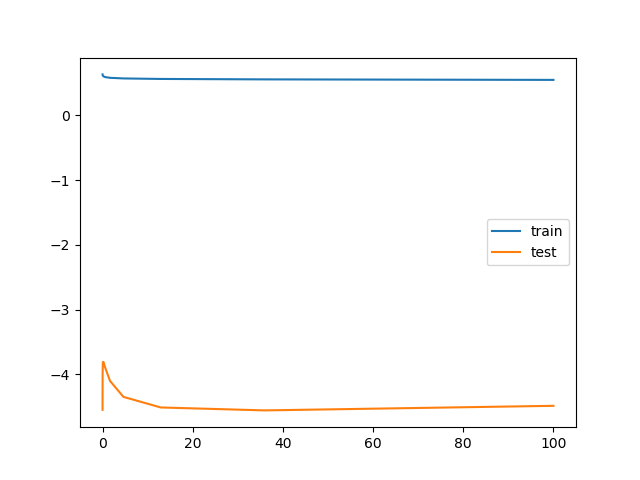

In [553]:
alphas = np.logspace(-2,2,10)
train_scores = []
test_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    train, test, test_pred, test_act, train_pred, train_act = loco_cv(ridge,X,y,clean_data['sample'])
    train_scores.append(np.mean(train))
    test_scores.append(np.mean(test[[0,2,3,4]]))
    
fig, ax = plt.subplots()
ax.plot(alphas,train_scores,label='train')
ax.plot(alphas,test_scores,label='test')
#ax.set_ylim(-1,1)
ax.legend()

In [554]:
test_scores


[-4.546433883173609,
 -3.9877366304539503,
 -3.8105894456095903,
 -3.8058747403707973,
 -3.8963587066088428,
 -4.100461212859474,
 -4.346401871393842,
 -4.509859525122397,
 -4.555237313595976,
 -4.484521164638416]

In [17]:
def multi_min(arrays):
    mins = []
    for arr in arrays:
        mins.append(min(arr))
    return min(mins)

def multi_max(arrays):
    maxs = []
    for arr in arrays:
        maxs.append(max(arr))
    return max(maxs)

<IPython.core.display.Javascript object>

In [18]:
def estimator_test(estimator, **estimator_kwargs):
    
    est = estimator(**estimator_kwargs)
    
    clusters = clean_data['sample']
#     c = 'PDAC_COM3_01488'
#     train_idx = np.where(clusters!=c)
#     test_idx = np.where(clusters==c)
#     X_train = X[train_idx]
#     y_train= y[train_idx]
#     X_test = X[test_idx]
#     y_test = y[test_idx]
#     rf.fit(X_train,y_train)
#     train_score = rf.score(X_train,y_train)
#     test_score = rf.score(X_test,y_test)
#     print(train_score, test_score)
    train_scores, test_scores, test_pred, test_act, train_pred, train_act = loco_cv(est,X,y,clusters)
    print(np.mean(train_scores), np.mean(test_scores))
#     fig, ax = plt.subplots()
#     ax.scatter(train_scores, test_scores)
#     ax.scatter(np.mean(train_scores), np.mean(test_scores),marker='d')
#     ax.axhline(0,ls='--')
#     ax.axvline(0,ls='--')
#     ax.set_xlabel('train score')
#     ax.set_ylabel('test score')
    
    #plot train data
    fig1, ax1 = plt.subplots()
    for i, (pred, act) in enumerate(zip(train_pred, train_act)):
        ax1.scatter(act, pred,label=i)
    axmin = multi_min([ax1.get_xlim(),ax1.get_ylim()])
    axmax = multi_max([ax1.get_xlim(),ax1.get_ylim()])
    ax1.plot([axmin,axmax],[axmin,axmax],label='Ideal')
    ax1.legend()
    
    #plot test data
    fig2, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
    act_means = []
    pred_means = []
    for i, c in enumerate(np.unique(clusters)):
        ax = axes[np.int(i/3),i%3]
        ax.scatter(test_act[i],test_pred[i])
        ax.set_title(c)
        axmin = min(min(test_act[i]),min(test_pred[i]))
        axmax = max(max(test_act[i]),max(test_pred[i]))
        ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
        ax.axhline(np.mean(test_act[i]),ls='--',c='k',label='Actual Cluster Mean')
        ax.axhline(np.mean(test_pred[i]),ls='--',c='r',label='Predicted Cluster Mean')
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        #ax.legend()
        fig2.tight_layout()
        
        act_means.append(np.mean(test_act[i]))
        pred_means.append(np.mean(test_pred[i]))
        
    #plot test cluster means
    fig3, ax3 = plt.subplots()
    ax3.scatter(act_means,pred_means)
    ax3.set_xlabel('Actual Cluster Mean')
    ax3.set_ylabel('Predicted Cluster Mean')
    axmin = min(min(act_means),min(pred_means))
    axmax = max(max(act_means),max(pred_means))
    ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax3.legend()
    

In [549]:
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
# X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']]
y = dc.clean_data['log_ASR']


#random forest
interact(
    estimator_test,
    estimator = [RandomForestRegressor],
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False]
        );

interactive(children=(Dropdown(description='estimator', options=(<class 'sklearn.ensemble.forest.RandomForestRegressor'>,), value=<class 'sklearn.ensemble.forest.RandomForestRegressor'>), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Output()), _dom_classes=('widget-interact',))

In [550]:
#AdaBoost

interact(
    estimator_test,
    estimator = [AdaBoostRegressor],
    n_estimators = [1,2,5,10,25,50],
    learning_rate = (0.0,1.5),
    loss = ['linear','square','exponential']
        );

interactive(children=(Dropdown(description='estimator', options=(<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>,), value=<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>), Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), FloatSlider(value=0.75, description='learning_rate', max=1.5), Dropdown(description='loss', options=('linear', 'square', 'exponential'), value='linear'), Output()), _dom_classes=('widget-interact',))

In [532]:
#gradient boosting
estimator = GradientBoostingRegressor

interact(
    estimator_test,
    estimator = [estimator],
    loss=['ls','lad','huber','quantile'],
    learning_rate = np.arange(0.05,1.01,0.05),
    n_estimators = [2,5,10,25,50,100],
    subsample = np.arange(0.2,1.01,0.2),
    max_depth = [1,2,3,5,10,20]
    );

interactive(children=(Dropdown(description='estimator', options=(<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>,), value=<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>), Dropdown(description='loss', options=('ls', 'lad', 'huber', 'quantile'), value='ls'), Dropdown(description='learning_rate', options=(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.8500000000000001, 0.9000000000000001, 0.9500000000000001, 1.0), value=0.05), Dropdown(description='n_estimators', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='subsample', options=(0.2, 0.4, 0.6000000000000001, 0.8, 1.0), value=0.2), Dropdown(description='max_depth', options=(1, 2, 3, 5, 10, 20), value=1), Output()), _dom_classes=('widget-interact',))

In [20]:
#elastic net
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
# X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']]

estimator = ElasticNet

interact(
    estimator_test,
    estimator = [estimator],
    alpha = np.logspace(-2,2,10),
    l1_ratio = (0.0,1.0)
    );

interactive(children=(Dropdown(description='estimator', options=(<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>,), value=<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>), Dropdown(description='alpha', options=(0.01, 0.027825594022071243, 0.0774263682681127, 0.21544346900318834, 0.5994842503189409, 1.6681005372000592, 4.6415888336127775, 12.915496650148826, 35.93813663804626, 100.0), value=0.01), FloatSlider(value=0.5, description='l1_ratio', max=1.0), Output()), _dom_classes=('widget-interact',))

In [631]:
from sklearn.model_selection import KFold

In [636]:
kf = KFold(n_splits=2)
Xx = ["a", "b", "c", "d"]
for train, test in kf.split(Xx):
    print(train, test)
    
train, test

[2 3] [0 1]
[0 1] [2 3]


(array([0, 1]), array([2, 3]))

In [ ]:
for cluster in np.unique(clusters):
    data_idx = np.where(clusters==cluster)
    test = 

def loco_cv_iterator(X):
    f
        

In [641]:
#elastic net CV
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
# X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']]

estimator = ElasticNetCV
gkf = GroupKFold(n_splits=5)


interact(
    estimator_test,
    estimator = [estimator],
    cv = [gkf.split(X,y,groups=clusters)],
    eps = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    l1_ratio = (0.0,1.0)
    );

interactive(children=(Dropdown(description='estimator', options=(<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>,), value=<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>), Dropdown(description='cv', options=(<generator object _BaseKFold.split at 0x0000020D5F4AFEB8>,), value=<generator object _BaseKFold.split at 0x0000020D5F4AFEB8>), Dropdown(description='eps', options=(0.0001, 0.0005, 0.001, 0.005, 0.01), value=0.0001), FloatSlider(value=0.5, description='l1_ratio', max=1.0), Output()), _dom_classes=('widget-interact',))

In [750]:
#monte carlo

class ClusterMonteCarlo():
    def __init__(self,X,y,clusters, sigma=1):
        self.X = X
        self.y = y
        self.y_init = y
        self.clusters = clusters
        self.unique_clusters = np.unique(clusters)
        self.sigma = sigma
        self.energy_hist = np.array([])
        self.offset_penalty_hist = np.array([])
        self.residual_sqsum_hist = np.array([])
        self.train_scores_hist = np.empty((0,len(self.unique_clusters)))
        self.test_scores_hist = np.empty((0,len(self.unique_clusters)))
        
    def trial_move(self):
        trial_y = self.y.copy()
        #choose a cluster at random
        cluster_idx = np.random.randint(0,len(self.unique_clusters))
        cluster = self.unique_clusters[cluster_idx]
        data_idx = np.where(self.clusters==cluster)
        #cluster_y = temp_y[data_idx]
        
        #shift chosen cluster by random amount within 3*sigma of y_init
        #mu_init = np.mean(y_init[data_idx])
        offset = 3*self.sigma*(np.random.rand()-0.5) #uniform distribution - could also do gaussian
        trial_y[data_idx] = self.y_init[data_idx] + offset
        
        return trial_y
    
    def set_estimator(self,estimator):
        self._estimator = estimator
        
    def get_estimator(self):
        return self._estimator
    
    estimator = property(get_estimator, set_estimator)
    
    def loco_cv(self,trial_y, get_predvact=False):
        train_scores = np.empty(len(self.unique_clusters))
        test_scores = np.empty(len(self.unique_clusters))
        test_vars = np.empty(len(self.unique_clusters))
        #for predvact
        train_act = []
        train_pred = []
        test_act = []
        test_pred = []
        train_clusters = []
        test_clusters = []
        for i, c in enumerate(self.unique_clusters):
            train_idx = np.where(self.clusters!=c)
            test_idx = np.where(self.clusters==c)
            X_train = self.X[train_idx]
            y_train= trial_y[train_idx]
            X_test = self.X[test_idx]
            y_test = trial_y[test_idx]
            self.estimator.fit(X_train,y_train)
            train_scores[i] = self.estimator.score(X_train,y_train)
            test_scores[i] = self.estimator.score(X_test,y_test)
            test_vars[i] = np.var(trial_y[test_idx])
            
            if get_predvact==True:
                train_pred.append(self.estimator.predict(X_train))
                train_act.append(y_train)
                train_clusters.append(self.clusters[train_idx])
                test_pred.append(self.estimator.predict(X_test))
                test_act.append(y_test)
                test_clusters.append(self.clusters[test_idx])
                
        if get_predvact==True:
            return train_scores, test_scores, test_vars, train_pred, train_act, test_pred, test_act, train_clusters, test_clusters
        else:
            return train_scores, test_scores, test_vars
    
    def offset_penalty(self,trial_y):
        #penalty term for total offset in y values
        return np.linalg.norm(trial_y - self.y_init, ord=2)
         
    def energy(self,trial_y,alpha,full=False):
        train_scores, test_scores, test_vars = self.loco_cv(trial_y)
        #residual sums for each test cluster
        test_residuals = test_vars*(1-test_scores)
        #total residual sum of squares
        test_sqsum = np.sum(test_residuals)
        penalty = alpha*self.offset_penalty(trial_y)
        #print("Loss: {}, Offset penalty: {}".format(test_sqsum,penalty))
        
        if full==True:
            return test_sqsum + penalty, test_sqsum, penalty, train_scores, test_scores
        else:
            return test_sqsum + penalty
    
    def accept_trial(self,dE,kT):
        if np.exp(-dE/kT) > np.random.rand():
            return True
        else:
            return False
        
    def run(self, kT, steps, alpha):
        energies = np.empty(steps)
        resids = np.empty(steps)
        penalties = np.empty(steps)
        train_scores = np.empty((steps, len(self.unique_clusters)))
        test_scores = np.empty((steps, len(self.unique_clusters)))
        for i in range(steps):
            trial_y = self.trial_move()
            if i==0:
                energy_0, resid0, penalty0, train_scores0, test_scores0 = self.energy(self.y,alpha,full=True)
            else:
                energy_0 = energies[i - 1]
                resid0 = resids[i - 1]
                penalty0 = penalties[i - 1]
            energy_1, resid1, penalty1, train_scores1, test_scores1 = self.energy(trial_y,alpha,full=True)
            dE = energy_1 - energy_0
            
            if self.accept_trial(dE,kT):
                #trial move accepted. update energy and y values
                self.y = trial_y
                energies[i] = energy_1
                resids[i] = resid1
                penalties[i] = penalty1
                train_scores[i] = train_scores1
                test_scores[i] = test_scores1
            else:
                #trial move rejected. energy and y values remain unchanged
                energies[i] = energy_0
                resids[i] = resid0
                penalties[i] = penalty0
                train_scores[i] = train_scores0
                test_scores[i] = test_scores0
        
        self.energy_hist = np.concatenate((self.energy_hist,energies))
        self.residual_sqsum_hist = np.concatenate((self.residual_sqsum_hist,resids))
        self.offset_penalty_hist = np.concatenate((self.offset_penalty_hist,penalties))
        self.train_scores_hist = np.concatenate((self.train_scores_hist,train_scores))
        self.test_scores_hist = np.concatenate((self.test_scores_hist,test_scores))
        return energies
    
    def reset(self):
        self.y = self.y_init
        self.energy_hist = np.array([])
        self.offset_penalty_hist = np.array([])
        self.residual_sqsum_hist = np.array([])
        self.test_scores_hist = np.array([])
        self.train_scores_hist = np.empty((0,len(self.unique_clusters)))
        self.test_scores_hist = np.empty((0,len(self.unique_clusters)))
        
    def get_offsets(self):
        offsets = {}
        for cluster in self.unique_clusters:
            data_idx = np.where(self.clusters==cluster)
            offsets[cluster] = np.mean(self.y[data_idx] - self.y_init[data_idx])
        return offsets
            
        
    

In [751]:
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
#X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']].values
y = dc.clean_data['log_ASR'].values
clusters = dc.clean_data['sample'].values
sigma = 1

cmc = ClusterMonteCarlo(X,y,clusters,sigma=sigma)
#cmc.estimator = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1)
#cmc.estimator = RandomForestRegressor(n_estimators=5, max_features=4, max_depth=10,random_state=0)
#cmc.estimator = Ridge(alpha=10)
cmc.estimator = ElasticNet(alpha=0.1,l1_ratio=0.9)

In [752]:
cmc.reset()
cmc.run(1,50,alpha=0.1)
cmc.run(0.5,50,alpha=0.1)
cmc.run(0.25,100,alpha=0.1)
cmc.run(0.1,100,alpha=0.1)
cmc.run(0.05,100,alpha=0.1)
cmc.run(0.025,100,alpha=0.1)
cmc.run(0.01,100,alpha=0.1)

array([2.51993309, 2.51993309, 2.51993309, 2.51993309, 2.51993309,
       2.51993309, 2.51993309, 2.51993309, 2.51993309, 2.51993309,
       2.51993309, 2.51993309, 2.51993309, 2.51993309, 2.51993309,
       2.51993309, 2.51993309, 2.51993309, 2.51993309, 2.51993309,
       2.51993309, 2.51993309, 2.51993309, 2.51993309, 2.51993309,
       2.51993309, 2.51993309, 2.48409462, 2.48409462, 2.48409462,
       2.48409462, 2.48409462, 2.48409462, 2.48409462, 2.48409462,
       2.48409462, 2.48409462, 2.48409462, 2.48409462, 2.48409462,
       2.48409462, 2.48409462, 2.48409462, 2.48409462, 2.48409462,
       2.48409462, 2.48409462, 2.48409462, 2.48409462, 2.50145792,
       2.50145792, 2.50145792, 2.50145792, 2.50145792, 2.50145792,
       2.50145792, 2.50145792, 2.50145792, 2.50145792, 2.50145792,
       2.50145792, 2.50145792, 2.50145792, 2.50145792, 2.50145792,
       2.50145792, 2.50145792, 2.50145792, 2.50145792, 2.50145792,
       2.50145792, 2.50145792, 2.50145792, 2.50145792, 2.50145

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


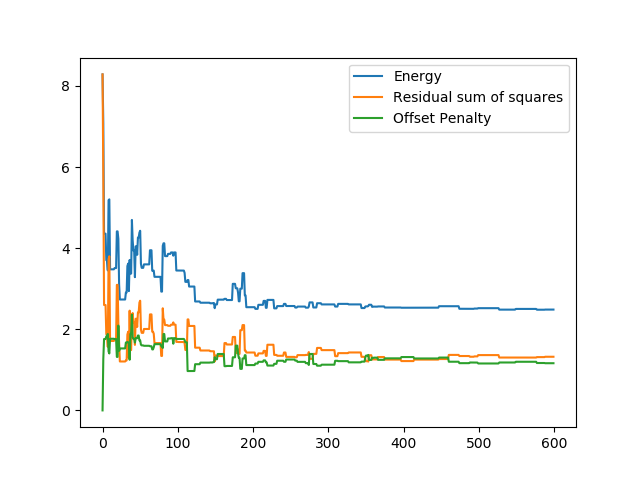

<IPython.core.display.Javascript object>


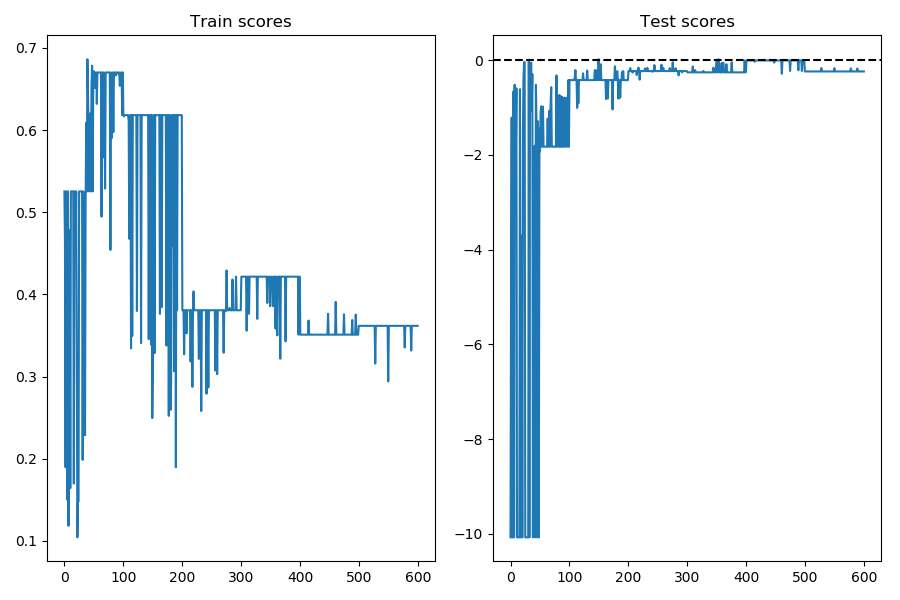

Text(0.5,1,'Test scores')

In [753]:
fig, ax = plt.subplots()
ax.plot(cmc.energy_hist,label='Energy')
ax.plot(cmc.residual_sqsum_hist,label='Residual sum of squares')
ax.plot(cmc.offset_penalty_hist,label='Offset Penalty')
ax.legend()

fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(9,6))
# for i,c in enumerate(cmc.unique_clusters):
#     ax1.plot(cmc.train_scores_hist[:,i],label=c)
#     ax2.plot(cmc.test_scores_hist[:,i],label=c)
ax1.plot(np.mean(cmc.train_scores_hist,axis=1))
ax2.plot(np.mean(cmc.test_scores_hist,axis=1))
ax2.axhline(0,c='k',ls='--')
# ax1.legend()
# ax2.legend()
ax1.set_title('Train scores')
ax2.set_title('Test scores')

In [754]:
cmc.get_offsets()

{'PDAC_COM3_01488': 0.2085039757480915,
 'PDAC_COM3_01504': 0.44220095908434986,
 'PDAC_COM3_01533': -0.17419312570675943,
 'PDAC_COM3_01535': 0.5352511038385419,
 'PDAC_COM3_01564': -0.7011747727601334}

In [755]:
train_scores, test_scores, test_vars, train_pred, train_act, test_pred, test_act, train_clusters, test_clusters = cmc.loco_cv(cmc.y,get_predvact=True)

test_scores

array([-0.05790909, -0.48168466, -0.01140596, -0.16930273, -0.14747086])

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


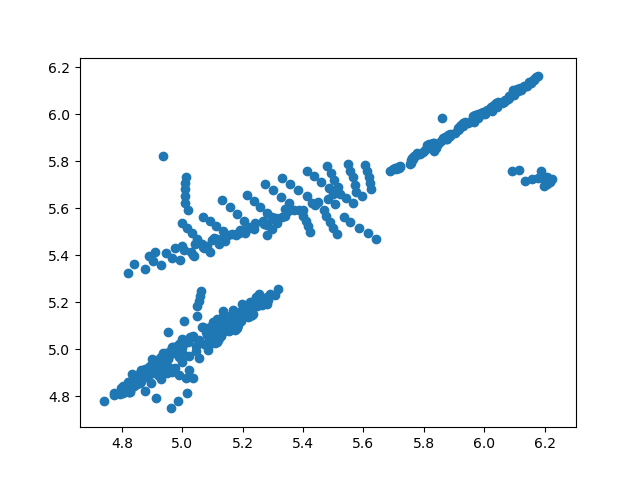

In [707]:
fig, ax = plt.subplots()
ax.scatter(train_pred[0], train_pred[1][:513])

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


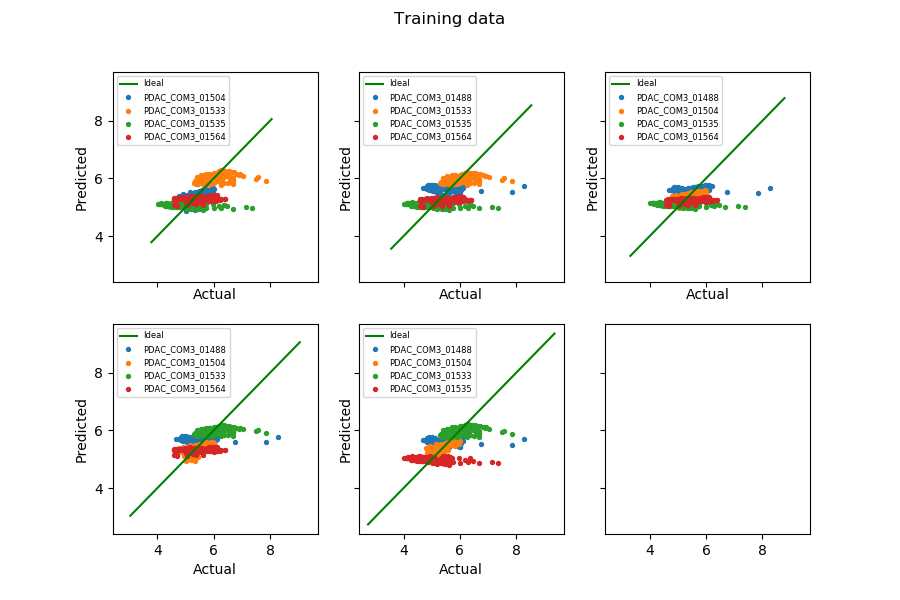

<IPython.core.display.Javascript object>


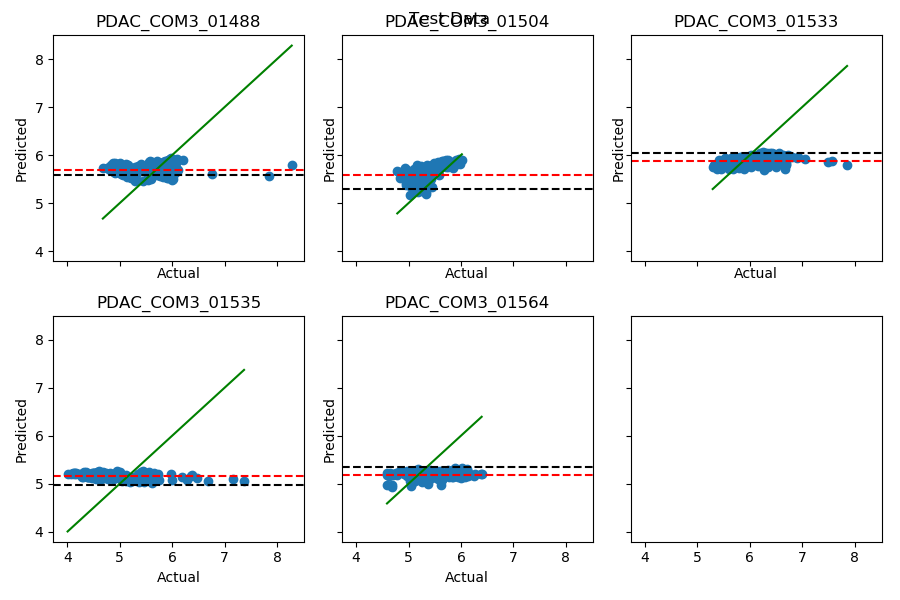

<IPython.core.display.Javascript object>


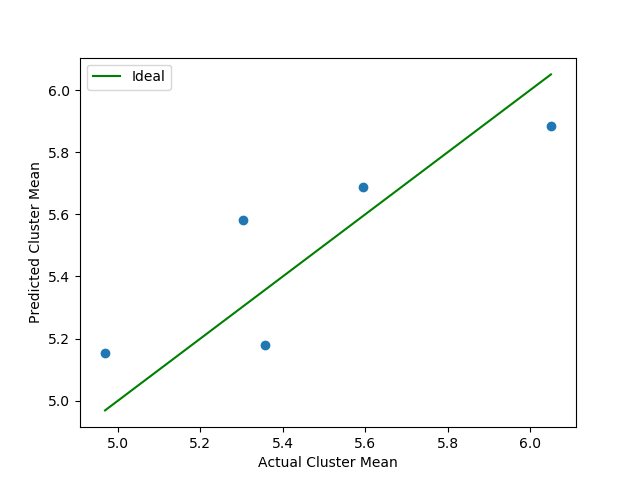

In [759]:
#plot train data
fig1, ax1 = plt.subplots(2,3,figsize=(9,6),sharex=True, sharey=True)
for i, (c, pred, act) in enumerate(zip(train_clusters, train_pred, train_act)):
    ax = ax1[np.int(i/3),i%3]
    for cluster in np.unique(c):
        idx = np.where(c==cluster)
        cp = pred[idx]
        ca = act[idx]
        ax.scatter(ca, cp,label=cluster,s=8)
    axmin = multi_min([ax.get_xlim(),ax.get_ylim()])
    axmax = multi_max([ax.get_xlim(),ax.get_ylim()])
    ax.plot([axmin,axmax],[axmin,axmax],label='Ideal',c='g')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(fontsize=6)
fig1.suptitle('Training data')
fig2.tight_layout()

#plot test data
fig2, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
act_means = []
pred_means = []
for i, c in enumerate(np.unique(clusters)):
    ax = axes[np.int(i/3),i%3]
    ax.scatter(test_act[i],test_pred[i])
    ax.set_title(c)
    axmin = min(min(test_act[i]),min(test_pred[i]))
    axmax = max(max(test_act[i]),max(test_pred[i]))
    ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax.axhline(np.mean(test_act[i]),ls='--',c='k',label='Actual Cluster Mean')
    ax.axhline(np.mean(test_pred[i]),ls='--',c='r',label='Predicted Cluster Mean')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    #ax.legend()

    act_means.append(np.mean(test_act[i]))
    pred_means.append(np.mean(test_pred[i]))
fig2.suptitle('Test Data')
fig2.tight_layout()
    
    
#plot test cluster means
fig3, ax3 = plt.subplots()
ax3.scatter(act_means,pred_means)
ax3.set_xlabel('Actual Cluster Mean')
ax3.set_ylabel('Predicted Cluster Mean')
axmin = min(min(act_means),min(pred_means))
axmax = max(max(act_means),max(pred_means))
ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
ax3.legend()

# monte carlo with validation 

In [788]:
#monte carlo

class ClusterMonteCarlo2():
    def __init__(self,X,y,clusters,validation_clusters,sigma=1):
        self.X = X
        self.y = y
        self.y_init = y
        self.clusters = clusters
        self.validation_clusters = validation_clusters
        self.sigma = sigma
        
        self.unique_clusters = np.unique(clusters)
        self.build_clusters = np.setdiff1d(self.unique_clusters,validation_clusters)
        #self.unique_clusters[np.where(np.isin(self.unique_clusters,self.validation_clusters)==False)]
        
        self.energy_hist = np.array([])
        self.offset_penalty_hist = np.array([])
        self.residual_sqsum_hist = np.array([])
        self.train_scores_hist = np.empty((0,len(self.build_clusters)))
        self.test_scores_hist = np.empty((0,len(self.build_clusters)))
        
    @property
    def X_val(self):
        idx = np.where(np.isin(self.clusters,self.validation_clusters))
        return self.X[idx]
    
    @property
    def y_val(self):
        idx = np.where(np.isin(self.clusters,self.validation_clusters))
        return self.y[idx]
    
    @property
    def X_build(self):
        idx = np.where(np.isin(self.clusters,self.build_clusters))
        return self.X[idx]
    
    @property
    def y_build(self):
        idx = np.where(np.isin(self.clusters,self.build_clusters))
        return self.y[idx]
    
    def trial_move(self):
        trial_y = self.y.copy()
        #choose a build cluster at random
        cluster_idx = np.random.randint(0,len(self.build_clusters))
        cluster = self.build_clusters[cluster_idx]
        data_idx = np.where(self.clusters==cluster)
        
        #shift chosen cluster by random amount within 3*sigma of y_init
        offset = 3*self.sigma*(np.random.rand()-0.5) #uniform distribution - could also do gaussian
        trial_y[data_idx] = self.y_init[data_idx] + offset
        
        return trial_y
    
    def set_estimator(self,estimator):
        self._estimator = estimator
        
    def get_estimator(self):
        return self._estimator
    
    estimator = property(get_estimator, set_estimator)
    
    def loco_cv(self,trial_y, get_predvact=False):
        "perform loco cv on build clusters"
        train_scores = np.empty(len(self.build_clusters))
        test_scores = np.empty(len(self.build_clusters))
        test_vars = np.empty(len(self.build_clusters))
        #for predvact
        train_act = []
        train_pred = []
        test_act = []
        test_pred = []
        train_clusters = []
        test_clusters = []
        for i, c in enumerate(self.build_clusters):
            train_idx = np.where((self.clusters!=c) & (np.isin(self.clusters,self.validation_clusters)==False))
            test_idx = np.where(self.clusters==c)
            X_train = self.X[train_idx]
            y_train= trial_y[train_idx]
            X_test = self.X[test_idx]
            y_test = trial_y[test_idx]
            self.estimator.fit(X_train,y_train)
            train_scores[i] = self.estimator.score(X_train,y_train)
            test_scores[i] = self.estimator.score(X_test,y_test)
            test_vars[i] = np.var(trial_y[test_idx])
            
            if get_predvact==True:
                train_pred.append(self.estimator.predict(X_train))
                train_act.append(y_train)
                train_clusters.append(self.clusters[train_idx])
                test_pred.append(self.estimator.predict(X_test))
                test_act.append(y_test)
                test_clusters.append(self.clusters[test_idx])
                
        if get_predvact==True:
            return train_scores, test_scores, test_vars, train_pred, train_act, test_pred, test_act, train_clusters, test_clusters
        else:
            return train_scores, test_scores, test_vars
    
    def offset_penalty(self,trial_y):
        #penalty term for total offset in y values
        return np.linalg.norm(trial_y - self.y_init, ord=2)
         
    def energy(self,trial_y,alpha,full=False):
        train_scores, test_scores, test_vars = self.loco_cv(trial_y)
        #residual sums for each test cluster
        test_residuals = test_vars*(1-test_scores)
        #total residual sum of squares
        test_sqsum = np.sum(test_residuals)
        penalty = alpha*self.offset_penalty(trial_y)
        #print("Loss: {}, Offset penalty: {}".format(test_sqsum,penalty))
        
        if full==True:
            return test_sqsum + penalty, test_sqsum, penalty, train_scores, test_scores
        else:
            return test_sqsum + penalty
    
    def accept_trial(self,dE,kT):
        if np.exp(-dE/kT) > np.random.rand():
            return True
        else:
            return False
        
    def run(self, kT, steps, alpha):
        energies = np.empty(steps)
        resids = np.empty(steps)
        penalties = np.empty(steps)
        train_scores = np.empty((steps, len(self.build_clusters)))
        test_scores = np.empty((steps, len(self.build_clusters)))
        for i in range(steps):
            trial_y = self.trial_move()
            if i==0:
                energy_0, resid0, penalty0, train_scores0, test_scores0 = self.energy(self.y,alpha,full=True)
            else:
                energy_0 = energies[i - 1]
                resid0 = resids[i - 1]
                penalty0 = penalties[i - 1]
            energy_1, resid1, penalty1, train_scores1, test_scores1 = self.energy(trial_y,alpha,full=True)
            dE = energy_1 - energy_0
            
            if self.accept_trial(dE,kT):
                #trial move accepted. update energy and y values
                self.y = trial_y
                energies[i] = energy_1
                resids[i] = resid1
                penalties[i] = penalty1
                train_scores[i] = train_scores1
                test_scores[i] = test_scores1
            else:
                #trial move rejected. energy and y values remain unchanged
                energies[i] = energy_0
                resids[i] = resid0
                penalties[i] = penalty0
                train_scores[i] = train_scores0
                test_scores[i] = test_scores0
        
        self.energy_hist = np.concatenate((self.energy_hist,energies))
        self.residual_sqsum_hist = np.concatenate((self.residual_sqsum_hist,resids))
        self.offset_penalty_hist = np.concatenate((self.offset_penalty_hist,penalties))
        self.train_scores_hist = np.concatenate((self.train_scores_hist,train_scores))
        self.test_scores_hist = np.concatenate((self.test_scores_hist,test_scores))
        return energies
    
    def reset(self):
        self.y = self.y_init
        self.energy_hist = np.array([])
        self.offset_penalty_hist = np.array([])
        self.residual_sqsum_hist = np.array([])
        self.test_scores_hist = np.array([])
        self.train_scores_hist = np.empty((0,len(self.build_clusters)))
        self.test_scores_hist = np.empty((0,len(self.build_clusters)))
        
    def get_offsets(self):
        offsets = {}
        for cluster in self.unique_clusters:
            data_idx = np.where(self.clusters==cluster)
            offsets[cluster] = np.mean(self.y[data_idx] - self.y_init[data_idx])
        return offsets
    
    def validate(self):
        self.estimator.fit(self.X_build,self.y_build)
        score = self.estimator.score(self.X_val,self.y_val)
        pred = self.estimator.predict(self.X_val)
        act = self.y_val
        
        return pred, act, score
        
    

In [809]:
cmc2.unique_clusters

array(['PDAC_COM3_01488', 'PDAC_COM3_01504', 'PDAC_COM3_01533',
       'PDAC_COM3_01535', 'PDAC_COM3_01564'], dtype=object)

In [831]:
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
#X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']].values
y = dc.clean_data['log_ASR'].values
clusters = dc.clean_data['sample'].values
sigma = 1

cmc2 = ClusterMonteCarlo2(X,y,clusters,validation_clusters=['PDAC_COM3_01564'],sigma=sigma)
#cmc.estimator = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1)
#cmc.estimator = RandomForestRegressor(n_estimators=5, max_features=4, max_depth=10,random_state=0)
#cmc.estimator = Ridge(alpha=10)
cmc2.estimator = ElasticNet(alpha=0.1,l1_ratio=0.9)

In [832]:
alpha = 0.1
cmc2.reset()
ival_pred, ival_act, ival_score = cmc2.validate()
cmc2.run(1,50,alpha)
cmc2.run(0.5,50,alpha)
cmc2.run(0.25,100,alpha)
cmc2.run(0.1,100,alpha)
cmc2.run(0.05,100,alpha)
cmc2.run(0.025,100,alpha)
cmc2.run(0.01,100,alpha)

array([1.51949239, 1.51949239, 1.51949239, 1.51949239, 1.51949239,
       1.51949239, 1.51949239, 1.51949239, 1.51949239, 1.51949239,
       1.51949239, 1.51949239, 1.51949239, 1.51949239, 1.51949239,
       1.51949239, 1.51949239, 1.51949239, 1.51949239, 1.51949239,
       1.51949239, 1.51949239, 1.51877598, 1.51877598, 1.51877598,
       1.51877598, 1.51877598, 1.51877598, 1.51877598, 1.51877598,
       1.51877598, 1.51877598, 1.51877598, 1.51877598, 1.51877598,
       1.51877598, 1.51877598, 1.51877598, 1.51877598, 1.51877598,
       1.51877598, 1.51877598, 1.51877598, 1.51877598, 1.51877598,
       1.51877598, 1.51877598, 1.51877598, 1.51877598, 1.51877598,
       1.51877598, 1.51449382, 1.51449382, 1.51449382, 1.51248302,
       1.51248302, 1.51248302, 1.49726417, 1.49726417, 1.49726417,
       1.49726417, 1.49726417, 1.49726417, 1.49726417, 1.49726417,
       1.49726417, 1.49726417, 1.49726417, 1.49726417, 1.49726417,
       1.49726417, 1.49726417, 1.49726417, 1.49726417, 1.49726

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


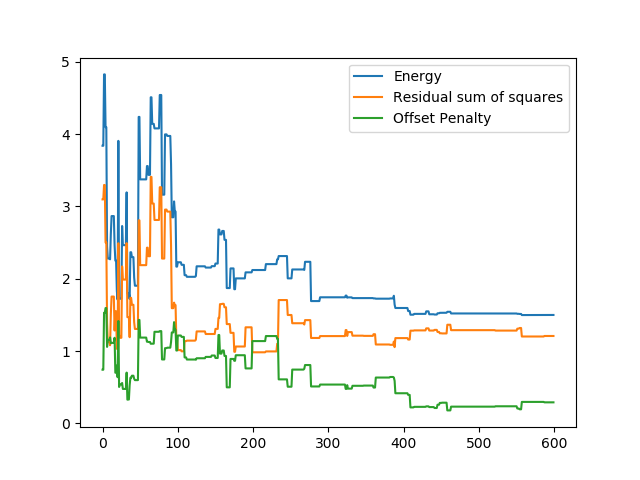

<IPython.core.display.Javascript object>


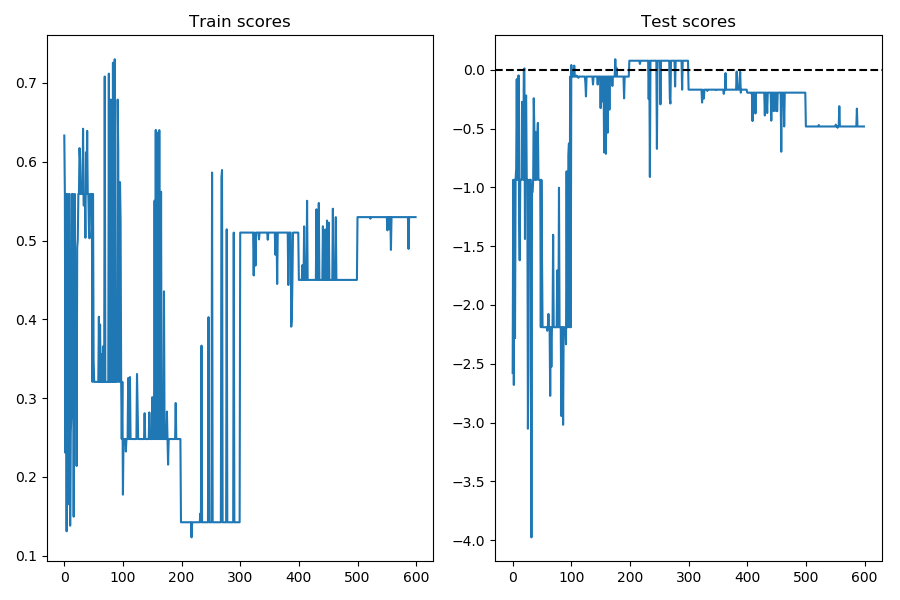

Text(0.5,1,'Test scores')

In [833]:
fig, ax = plt.subplots()
ax.plot(cmc2.energy_hist,label='Energy')
ax.plot(cmc2.residual_sqsum_hist,label='Residual sum of squares')
ax.plot(cmc2.offset_penalty_hist,label='Offset Penalty')
ax.legend()

fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(9,6))
# for i,c in enumerate(cmc.unique_clusters):
#     ax1.plot(cmc.train_scores_hist[:,i],label=c)
#     ax2.plot(cmc.test_scores_hist[:,i],label=c)
ax1.plot(np.mean(cmc2.train_scores_hist,axis=1))
ax2.plot(np.mean(cmc2.test_scores_hist,axis=1))
ax2.axhline(0,c='k',ls='--')
# ax1.legend()
# ax2.legend()
ax1.set_title('Train scores')
ax2.set_title('Test scores')

In [834]:
cmc2.get_offsets()

{'PDAC_COM3_01488': -0.006538811378684173,
 'PDAC_COM3_01504': 0.1123760377363423,
 'PDAC_COM3_01533': -0.22528979015212514,
 'PDAC_COM3_01535': 0.061456442720706474,
 'PDAC_COM3_01564': 0.0}

In [835]:
train_scores, test_scores, test_vars, train_pred, train_act, test_pred, test_act, train_clusters, test_clusters = cmc2.loco_cv(cmc2.y,get_predvact=True)
test_scores

array([-0.05935606, -0.91771019, -0.14980754, -0.19366656])

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


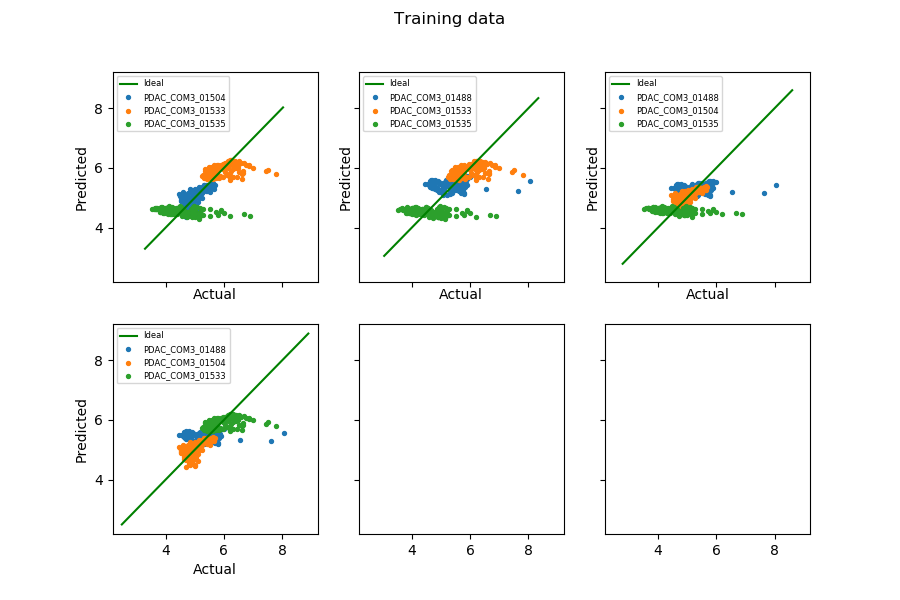

<IPython.core.display.Javascript object>


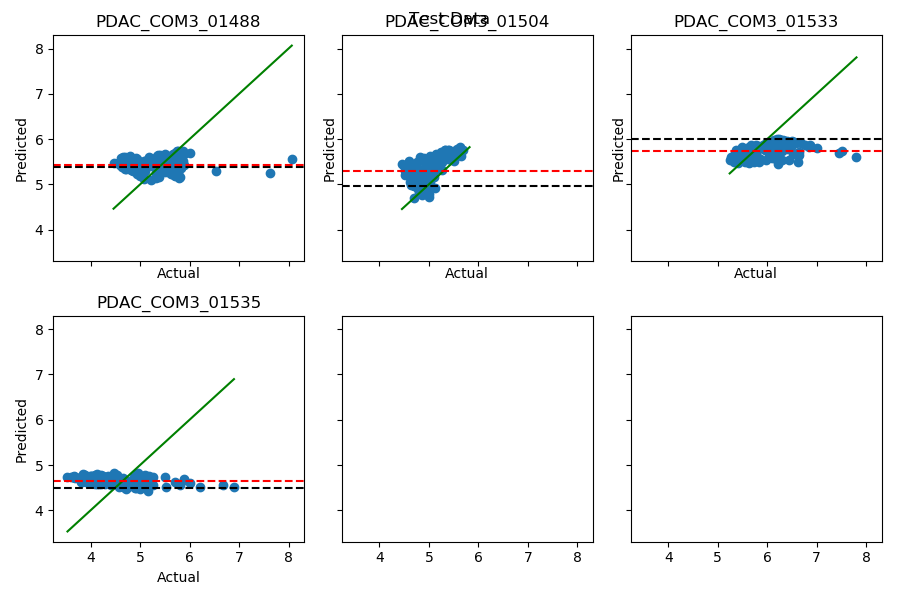

<IPython.core.display.Javascript object>


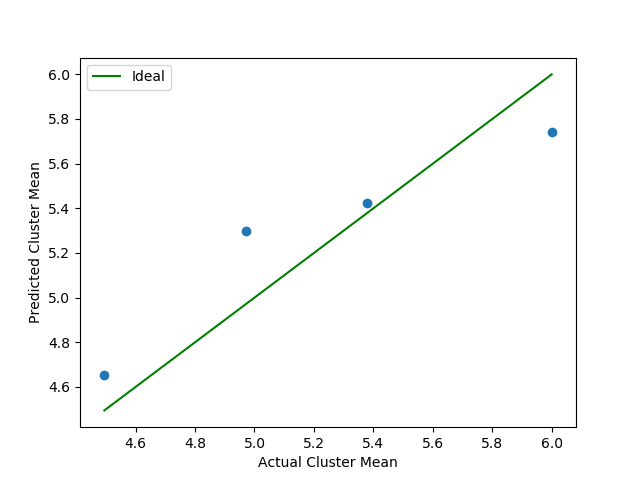

In [836]:
#plot train data
fig1, ax1 = plt.subplots(2,3,figsize=(9,6),sharex=True, sharey=True)
for i, (c, pred, act) in enumerate(zip(train_clusters, train_pred, train_act)):
    ax = ax1[np.int(i/3),i%3]
    for cluster in np.unique(c):
        idx = np.where(c==cluster)
        cp = pred[idx]
        ca = act[idx]
        ax.scatter(ca, cp,label=cluster,s=8)
    axmin = multi_min([ax.get_xlim(),ax.get_ylim()])
    axmax = multi_max([ax.get_xlim(),ax.get_ylim()])
    ax.plot([axmin,axmax],[axmin,axmax],label='Ideal',c='g')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(fontsize=6)
fig1.suptitle('Training data')
fig2.tight_layout()

#plot test data
fig2, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
act_means = []
pred_means = []
for i, c in enumerate(cmc2.build_clusters):
    ax = axes[np.int(i/3),i%3]
    ax.scatter(test_act[i],test_pred[i])
    ax.set_title(c)
    axmin = min(min(test_act[i]),min(test_pred[i]))
    axmax = max(max(test_act[i]),max(test_pred[i]))
    ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax.axhline(np.mean(test_act[i]),ls='--',c='k',label='Actual Cluster Mean')
    ax.axhline(np.mean(test_pred[i]),ls='--',c='r',label='Predicted Cluster Mean')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    #ax.legend()

    act_means.append(np.mean(test_act[i]))
    pred_means.append(np.mean(test_pred[i]))
fig2.suptitle('Test Data')
fig2.tight_layout()
    
    
#plot test cluster means
fig3, ax3 = plt.subplots()
ax3.scatter(act_means,pred_means)
ax3.set_xlabel('Actual Cluster Mean')
ax3.set_ylabel('Predicted Cluster Mean')
axmin = min(min(act_means),min(pred_means))
axmax = max(max(act_means),max(pred_means))
ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
ax3.legend()

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


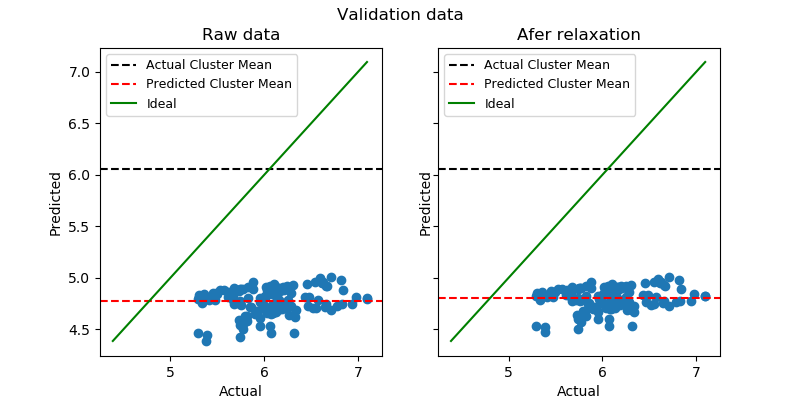

-9.654153506373842 -9.235545813236675


In [837]:
fval_pred, fval_act, fval_score = cmc2.validate()

fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

ax1 = axes[0]
ax2 = axes[1]

ax1.scatter(ival_act,ival_pred)
ax2.scatter(fval_act,fval_pred)


axmin = multi_min([fval_act,fval_pred,ival_act,ival_pred])
axmax = multi_max([fval_act,fval_pred,ival_act,ival_pred])
    
ax1.axhline(np.mean(ival_act),ls='--',c='k',label='Actual Cluster Mean')
ax1.axhline(np.mean(ival_pred),ls='--',c='r',label='Predicted Cluster Mean')
ax2.axhline(np.mean(fval_act),ls='--',c='k',label='Actual Cluster Mean')
ax2.axhline(np.mean(fval_pred),ls='--',c='r',label='Predicted Cluster Mean')

for ax in axes:
    ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(fontsize=9)

ax1.set_title('Raw data')
ax2.set_title('Afer relaxation')
fig.suptitle('Validation data')
print(ival_score,fval_score)

In [874]:
unique_clusters = ['PDAC_COM3_01488', 'PDAC_COM3_01504', 'PDAC_COM3_01533', 'PDAC_COM3_01535', 'PDAC_COM3_01564']

drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
#X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']].values
y = dc.clean_data['log_ASR'].values
clusters = dc.clean_data['sample'].values
sigma = 1

mc_alpha = 0.1

i_scores = np.array([])
f_scores = np.array([])
i_pred = np.array([])
i_act = np.array([])
f_pred = np.array([])
f_act = np.array([])
cluster_list = np.array([])

for vc in unique_clusters:
    cmc2 = ClusterMonteCarlo2(X,y,clusters,validation_clusters=[vc],sigma=sigma)
    cmc2.estimator = ElasticNet(alpha=0.1,l1_ratio=0.9)
    
    cmc2.reset()
    ival_pred, ival_act, ival_score = cmc2.validate()
    i_pred = np.concatenate((i_pred,ival_pred))
    i_act = np.concatenate((i_act,ival_act))
    i_scores = np.concatenate((i_scores,[ival_score]))
    
    cmc2.run(1,50,mc_alpha)
    cmc2.run(0.5,50,mc_alpha)
    cmc2.run(0.25,100,mc_alpha)
    cmc2.run(0.1,100,mc_alpha)
    cmc2.run(0.05,100,mc_alpha)
    cmc2.run(0.025,100,mc_alpha)
    cmc2.run(0.01,100,mc_alpha)
#     train_scores, test_scores, test_vars = cmc2.loco_cv(cmc2.y)
#     test_scores
    fval_pred, fval_act, fval_score = cmc2.validate()
    f_pred = np.concatenate((f_pred,fval_pred))
    f_act = np.concatenate((f_act,fval_act))
    f_scores = np.concatenate((f_scores,[fval_score]))
    
    cluster_list = np.concatenate((cluster_list, [vc]*len(ival_pred)))
    
print('done')    

done


-1.5747870200218457

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


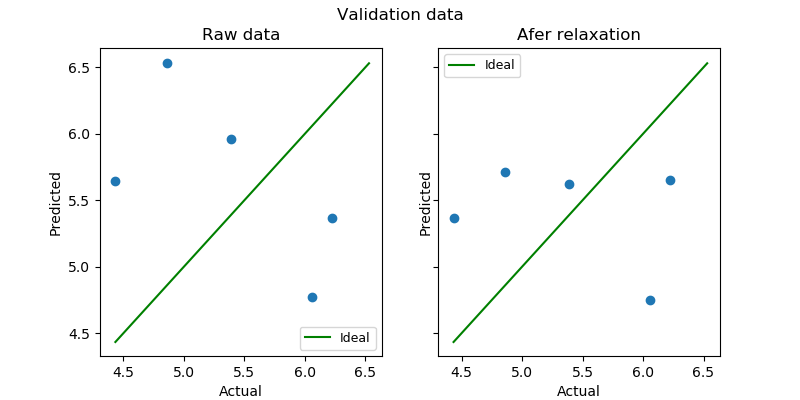

[ -1.57478702 -32.45208721  -3.05506751  -3.64624987  -9.65415351] [-0.22784865 -7.97149002 -1.23898229 -2.17799947 -9.96062565]


In [875]:
fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

ax1 = axes[0]
ax2 = axes[1]

ia_means = []
ip_means = []
fa_means = []
fp_means = []

for c in unique_clusters:
    idx = np.where(cluster_list==c)
    ia_means.append(np.mean(i_act[idx]))
    ip_means.append(np.mean(i_pred[idx]))
    fa_means.append(np.mean(f_act[idx]))
    fp_means.append(np.mean(f_pred[idx]))


ax1.scatter(ia_means,ip_means)
ax2.scatter(fa_means,fp_means)

axmin = multi_min([ia_means,ip_means,fa_means,fp_means])
axmax = multi_max([ia_means,ip_means,fa_means,fp_means])
    
# ax1.axhline(np.mean(i_act),ls='--',c='k',label='Actual Cluster Mean')
# ax1.axhline(np.mean(i_pred),ls='--',c='r',label='Predicted Cluster Mean')
# ax2.axhline(np.mean(f_act),ls='--',c='k',label='Actual Cluster Mean')
# ax2.axhline(np.mean(f_pred),ls='--',c='r',label='Predicted Cluster Mean')

for ax in axes:
    ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(fontsize=9)

ax1.set_title('Raw data')
ax2.set_title('Afer relaxation')
fig.suptitle('Validation data')
print(i_scores,f_scores)

In [873]:
#cluster_list.shape
np.shape([vc]*len(i_pred))

(645,)

# Obsolete functions

In [529]:
#obsolete functions


drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
#X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']].values

def fit_score(n_estimators, max_features, max_depth, min_samples_leaf, min_samples_split, criterion, bootstrap):
    
    rf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                               criterion=criterion,bootstrap=bootstrap,random_state=0)

    clusters = clean_data['sample']
#     c = 'PDAC_COM3_01488'
#     train_idx = np.where(clusters!=c)
#     test_idx = np.where(clusters==c)
#     X_train = X[train_idx]
#     y_train= y[train_idx]
#     X_test = X[test_idx]
#     y_test = y[test_idx]
#     rf.fit(X_train,y_train)
#     train_score = rf.score(X_train,y_train)
#     test_score = rf.score(X_test,y_test)
#     print(train_score, test_score)
    train_scores, test_scores, test_pred, test_act, train_pred, train_act = loco_cv(rf,X,y,clusters)
    print(np.mean(train_scores), np.mean(test_scores))
#     fig, ax = plt.subplots()
#     ax.scatter(train_scores, test_scores)
#     ax.scatter(np.mean(train_scores), np.mean(test_scores),marker='d')
#     ax.axhline(0,ls='--')
#     ax.axvline(0,ls='--')
#     ax.set_xlabel('train score')
#     ax.set_ylabel('test score')
    
    #plot train data
    fig1, ax1 = plt.subplots()
    for i, (pred, act) in enumerate(zip(train_pred, train_act)):
        ax1.scatter(act, pred,label=i,s=6)
    axmin = multi_min([ax1.get_xlim(),ax1.get_ylim()])
    axmax = multi_max([ax1.get_xlim(),ax1.get_ylim()])
    ax1.plot([axmin,axmax],[axmin,axmax],label='Ideal')
    ax1.legend()
    
    #plot test data
    fig2, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
    act_means = []
    pred_means = []
    for i, c in enumerate(np.unique(clusters)):
        ax = axes[np.int(i/3),i%3]
        ax.scatter(test_act[i],test_pred[i])
        ax.set_title(c)
        axmin = min(min(test_act[i]),min(test_pred[i]))
        axmax = max(max(test_act[i]),max(test_pred[i]))
        ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
        ax.axhline(np.mean(test_act[i]),ls='--',c='k',label='Actual Cluster Mean')
        ax.axhline(np.mean(test_pred[i]),ls='--',c='r',label='Predicted Cluster Mean')
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        #ax.legend()
        fig2.tight_layout()
        
        act_means.append(np.mean(test_act[i]))
        pred_means.append(np.mean(test_pred[i]))
        
    #plot test cluster means
    fig3, ax3 = plt.subplots()
    ax3.scatter(act_means,pred_means)
    ax3.set_xlabel('Actual Cluster Mean')
    ax3.set_ylabel('Predicted Cluster Mean')
    axmin = min(min(act_means),min(pred_means))
    axmax = max(max(act_means),max(pred_means))
    ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax3.legend()
    
    
interact(
    fit_score,
    n_estimators = [1,2,5,10,25,50],
    max_features = [1,2,3,4,5,10,20,None],
    max_depth = [1,2,5,10,20,None],
    min_samples_leaf = [1, 2, 5, 10, 25, 50],
    min_samples_split = [2, 5, 10, 25, 50, 100],
    criterion = ['mse','mae'],
    bootstrap = [True, False]
        );

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='max_features', options=(1, 2, 3, 4, 5, 10, 20, None), value=1), Dropdown(description='max_depth', options=(1, 2, 5, 10, 20, None), value=1), Dropdown(description='min_samples_leaf', options=(1, 2, 5, 10, 25, 50), value=1), Dropdown(description='min_samples_split', options=(2, 5, 10, 25, 50, 100), value=2), Dropdown(description='criterion', options=('mse', 'mae'), value='mse'), Dropdown(description='bootstrap', options=(True, False), value=True), Output()), _dom_classes=('widget-interact',))

In [538]:
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
X = input_2334.drop(drop,axis=1).values
# X = input_2334.loc[:,['Co_amt','Fe_amt','Zr_amt','Y_amt']].values

def fit_score2(n_estimators, **kw):
    
    ab = AdaBoostRegressor(n_estimators=n_estimators,**kw)
    
    clusters = clean_data['sample']
#     c = 'PDAC_COM3_01488'
#     train_idx = np.where(clusters!=c)
#     test_idx = np.where(clusters==c)
#     X_train = X[train_idx]
#     y_train= y[train_idx]
#     X_test = X[test_idx]
#     y_test = y[test_idx]
#     rf.fit(X_train,y_train)
#     train_score = rf.score(X_train,y_train)
#     test_score = rf.score(X_test,y_test)
#     print(train_score, test_score)
    train_scores, test_scores, test_pred, test_act, train_pred, train_act = loco_cv(ab,X,y,clusters)
    print(np.mean(train_scores), np.mean(test_scores))
#     fig, ax = plt.subplots()
#     ax.scatter(train_scores, test_scores)
#     ax.scatter(np.mean(train_scores), np.mean(test_scores),marker='d')
#     ax.axhline(0,ls='--')
#     ax.axvline(0,ls='--')
#     ax.set_xlabel('train score')
#     ax.set_ylabel('test score')
    
    #plot train data
    fig1, ax1 = plt.subplots()
    for i, (pred, act) in enumerate(zip(train_pred, train_act)):
        ax1.scatter(act, pred,label=i)
    axmin = multi_min([ax1.get_xlim(),ax1.get_ylim()])
    axmax = multi_max([ax1.get_xlim(),ax1.get_ylim()])
    ax1.plot([axmin,axmax],[axmin,axmax],label='Ideal')
    ax1.legend()
    
    #plot test data
    fig2, axes = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
    act_means = []
    pred_means = []
    for i, c in enumerate(np.unique(clusters)):
        ax = axes[np.int(i/3),i%3]
        ax.scatter(test_act[i],test_pred[i])
        ax.set_title(c)
        axmin = min(min(test_act[i]),min(test_pred[i]))
        axmax = max(max(test_act[i]),max(test_pred[i]))
        ax.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
        ax.axhline(np.mean(test_act[i]),ls='--',c='k',label='Actual Cluster Mean')
        ax.axhline(np.mean(test_pred[i]),ls='--',c='r',label='Predicted Cluster Mean')
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        #ax.legend()
        fig2.tight_layout()
        
        act_means.append(np.mean(test_act[i]))
        pred_means.append(np.mean(test_pred[i]))
        
    #plot test cluster means
    fig3, ax3 = plt.subplots()
    ax3.scatter(act_means,pred_means)
    ax3.set_xlabel('Actual Cluster Mean')
    ax3.set_ylabel('Predicted Cluster Mean')
    axmin = min(min(act_means),min(pred_means))
    axmax = max(max(act_means),max(pred_means))
    ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
    ax3.legend()
    
interact(
    fit_score2,
    n_estimators = [1,2,5,10,25,50],
    learning_rate = (0.0,1.5),
    loss = ['linear','square','exponential']
        );

interactive(children=(Dropdown(description='n_estimators', options=(1, 2, 5, 10, 25, 50), value=1), FloatSlider(value=0.75, description='learning_rate', max=1.5), Dropdown(description='loss', options=('linear', 'square', 'exponential'), value='linear'), Output()), _dom_classes=('widget-interact',))